# Задача 9. Hand-crafted graph features

- Найти или сгенерировать набор данных для бинарной классификации графов.
- Реализовать функцию shortest_path_kernel(train_graphs, test_graphs), которая принимает тренировочный и тестовые наборы, а возвращает пару K_train, K_test
    - Опишите графы с помощью вектора из количества кратчайших путей различной длины
    - Для вычисления длин кратчайших путей можно использовать nx.shortest_path_length(G)
    - Ядровая функция для сравнения двух графов - скалярное произведение их двух векторов
    - K_train - матрица из ядровых функций для сравнения тренировочных графов между собой
    - K_test - матрица из ядровых функций для сравнения тестовых графов с тренировочными
- Используя реализованное ядро обучите модель SVC, подберите гиперпараметры, вычислите различные метрики качества
- (+5 баллов) Также реализовать Weisfeiler-Lehman Kernel и обучить классификатор с ним, сравнить результаты.

In [ ]:
!pip install scikit-learn

In [117]:
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx
import random
import sklearn
import numpy as np

from sklearn.svm import SVC
from sklearn.metrics import classification_report
from networkx.generators import random_unlabeled_tree

## Данные

In [119]:
DATASET_SIZE = 1000
NUMBER_OF_NODES = 50

In [130]:
default_tree_graphs = [random_unlabeled_tree(NUMBER_OF_NODES) for _ in range(int(DATASET_SIZE * 0.5))]
cycled_graphs = [nx.cycle_graph(NUMBER_OF_NODES) for _ in range(int(DATASET_SIZE * 0.5))]

In [131]:
labels = [0] * len(cycled_graphs) + [1] * len(default_tree_graphs)
graphs = cycled_graphs + default_tree_graphs

In [132]:
random.shuffle(graphs)

In [133]:
train, test, y_train, y_test = sklearn.model_selection.train_test_split(graphs, labels, test_size=0.3, random_state=42)

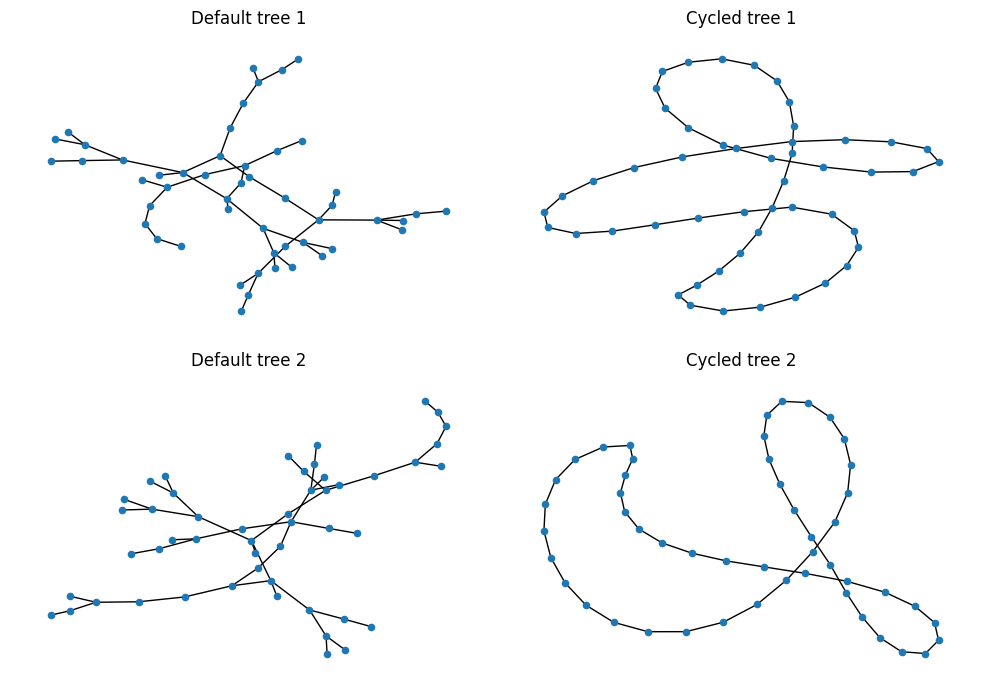

In [134]:
fig, axes = plt.subplots(2, 2, figsize=(10, 7))

for i in range(2):
    idx = y_train.index(0)
    nx.draw(train[idx], ax=axes[i, 0], node_size=20)
    axes[i, 0].set_title(f"Default tree {i+1}")
    
    idx = y_train.index(1)
    nx.draw(train[idx], ax=axes[i, 1], node_size=20)
    axes[i, 1].set_title(f"Cycled tree {i+1}")

plt.tight_layout()
plt.show()

## Shortest Path Kernel

In [135]:
def shortest_path_kernel(
    train_graphs,
    test_graphs,
    max_path_length: int = 5,
    n_samples: int = 10): 
    
    def compute_features(graphs):
        features = np.zeros((len(graphs), max_path_length))
        
        for i, graph in enumerate(graphs):
            valid_nodes = list(graph.nodes())
            
            for _ in range(n_samples):
                source, target = np.random.choice(valid_nodes, 2, replace=False)
                
                pl = nx.shortest_path_length(graph, source, target)
                    
                pl = min(pl, max_path_length - 1)
                features[i, pl] += 1
                
        return features

    phi_train = compute_features(train_graphs)
    phi_test = compute_features(test_graphs)

    phi_train = phi_train / n_samples
    phi_test = phi_test / n_samples

    K_train = phi_train @ phi_train.T
    K_test = phi_test @ phi_train.T

    return K_train, K_test

## Обучение классификатора

In [136]:
K_train, K_test = shortest_path_kernel(train, test)
model = SVC(random_state=42).fit(K_train, y_train)
y_pred = model.predict(K_test)

In [137]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.60      0.53       150
           1       0.46      0.35      0.40       150

    accuracy                           0.47       300
   macro avg       0.47      0.47      0.46       300
weighted avg       0.47      0.47      0.46       300



## Подбор гиперпараметров

In [138]:
MAX_PATH_LENGTHS = [1, 5, 10, 15, 20, 30]
SAMPLES_COUNT = [1, 10, 20, 30, 40, 50]

def search_best_params(max_paths, samples_counts, train_graphs, test_graps):
    for max_path in max_paths:
        for samples_count in samples_counts:
            K_train, K_test = shortest_path_kernel(train_graphs, 
                                                   test_graps, 
                                                   max_path_length=max_path,
                                                   n_samples=samples_count)
            model = SVC(random_state=42)
            model.fit(K_train, y_train)
            y_pred = model.predict(K_test)

            print(f"Metrics for param MAX_PATH_LENGTHS={max_path} and SAMPLES_COUNT={samples_count}")
            print(classification_report(y_test, y_pred, zero_division=0))

In [139]:
search_best_params(MAX_PATH_LENGTHS, SAMPLES_COUNT, train, test)

Metrics for param MAX_PATH_LENGTHS=1 and SAMPLES_COUNT=1
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       150
           1       0.50      1.00      0.67       150

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300

Metrics for param MAX_PATH_LENGTHS=1 and SAMPLES_COUNT=10
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       150
           1       0.50      1.00      0.67       150

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300

Metrics for param MAX_PATH_LENGTHS=1 and SAMPLES_COUNT=20
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       150
           1       0.50      1.00      0.67       150

    accur

## Weisfeiler-Lehman Kernel

In [140]:
def wl_kernel_helper(
    graph,
    iterations: int = 3,
    limit: int = 1024
):
    node_colors = {node: 1 for node in graph.nodes}
    neighbor_cache = {node: list(nx.neighbors(graph, node)) for node in graph.nodes}
    color_memo = {}
    unique_color_counter = 2

    for _ in range(iterations):
        neighbor_features = {}
        for node in graph.nodes:
            n_colors = tuple(sorted(node_colors[n] for n in neighbor_cache[node]))
            neighbor_features[node] = (node_colors[node], n_colors)

        feature_groups = defaultdict(list)
        for node, features in neighbor_features.items():
            feature_groups[features].append(node)

        new_colors = {}
        for features, nodes in feature_groups.items():
            if features not in color_memo:
                color_memo[features] = unique_color_counter
                unique_color_counter += 1
            
            new_color = color_memo[features] % limit 
            for node in nodes:
                new_colors[node] = new_color

        node_colors = new_colors

    histogram = np.zeros(limit, dtype=np.int32)
    for color in node_colors.values():
        histogram[color] += 1
        
    return histogram / histogram.sum()

def wl_kernel(
    train_graphs,
    test_graphs,
    iterations: int = 3,
    limit: int = 1024
):
    phi_train = np.array([wl_kernel_helper(g, iterations, limit) for g in train_graphs])
    
    phi_test = np.array([wl_kernel_helper(g, iterations, limit) for g in test_graphs])

    K_train = phi_train @ phi_train.T
    K_test = phi_test @ phi_train.T

    return K_train, K_test

In [144]:
K_train_gk, K_test_gk = wl_kernel(train, test)
model = SVC(random_state=42)

model.fit(K_train_gk, y_train)
y_pred = model.predict(K_test_gk)

In [145]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.53      0.51       150
           1       0.49      0.45      0.47       150

    accuracy                           0.49       300
   macro avg       0.49      0.49      0.49       300
weighted avg       0.49      0.49      0.49       300

